In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
import scipy.integrate as integrate
from scipy.linalg import ishermitian

In [2]:
def nfib(n):
    def fib(k):
        if k == 0:
            return (0, 1)
        else:
            a, b = fib(k >> 1)
            c = a * ((b << 1) - a)
            d = a * a + b * b
            if k & 1:
                return (d, c + d)
            else:
                return (c, d)
    return fib(n)[0]

w2 = 0.1
fib = 10
p = nfib(fib)
q = nfib(fib-1)
w1 = (p/q)*w2
w = w2/q
latsize = 1
phi1 = 0
phi2 = 0
m = 1

In [3]:
sigmax = np.matrix([[0, 1],[1, 0]], dtype=complex)
sigmay = np.matrix([[0, -1j],[1j, 0]], dtype=complex)
sigmaz = np.matrix([[1, 0j],[0, -1]], dtype=complex)

def temporalBHZ(w1, phi1, w2, phi2, m, t):
    return np.sin(w1*t+phi1)*sigmax + np.sin(w2*t+phi2)*sigmay + (m - np.cos(w1*t+phi1) - np.cos(w2*t+phi2))*sigmaz

def dh1t(w1, phi1, t):
    return w1*(np.sin(w1*t+phi1+t)*sigmaz +np.cos(w1*t+phi1)*sigmax)
def dh2t(w2, phi2, t):
    return w2*(np.sin(w2*t+phi2+t)*sigmaz +np.cos(w2*t+phi2)*sigmay)    

We use the evolution operator caluclated using the dyson series, and the derivatives of hamiltonian as calculated above. 

In [120]:
def simpson1(f, a, b):
    res = f(a) + f(b) + 4*f((a+b)/2)
    return (b-a)*res/6
def simpson2(g, a, b, c, d): # a and b are x limits. c and d are y limits
    hx, hy = b - a, d - c
    t1 = g(a, c) + g(b, c) + g(a, d) + g(b, d)
    t2 = g((a+b)/2, c) + g((a+b)/2, d) + g(a, (c+d)/2) + g(b, (c+d)/2)
    t3 = g((a+b)/2, (c+d)/2)
    return hx*hy*(t1 + 4*t2 + 16*t3)/36 
    

def U(m, t):
    h1 = lambda t: temporalBHZ(w1, phi1, w2, phi2, m, t)
    h2 = lambda t1, t2: temporalBHZ(w1, phi1, w2, phi2, m, t1) @ temporalBHZ(w1, phi1, w2, phi2, m, t2)
    h0 = np.matrix(np.eye(2, dtype=complex))

    t1 = simpson1(h1, 0, t)
    t2 = simpson2(h2, 0, t, 0, t/3)
    mat = h0 - (1j)*t1 - t2
    return (1/np.sqrt(la.det(mat)))*mat

In [126]:
m = 1.5
def work1(w1, phi1, ti, tf):
    def op(w1, phi1, t):
        return U(m, t).H @ dh1t(w1, phi1, t) @ U(m, t)
    res = np.zeros((2,2), dtype=complex)
    res[0,0] = integrate.quad(lambda t: np.real(op(w1, phi1, t)[0,0]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w1, phi1, t)[0,0]), ti, tf)[0]
    res[0,1] = integrate.quad(lambda t: np.real(op(w1, phi1, t)[0,1]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w1, phi1, t)[0,1]), ti, tf)[0]
    res[1,0] = integrate.quad(lambda t: np.real(op(w1, phi1, t)[1,0]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w1, phi1, t)[1,0]), ti, tf)[0]
    res[1,1] = integrate.quad(lambda t: np.real(op(w1, phi1, t)[1,1]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w1, phi1, t)[1,1]), ti, tf)[0]
    return np.matrix(res)
    
def work2(w2, phi2, ti, tf):
    def op(w2, phi2, t):
        return U(m, t).H @ dh2t(w2, phi2, t) @ U(m, t)
    res = np.zeros((2,2), dtype=complex)
    res[0,0] = integrate.quad(lambda t: np.real(op(w2, phi2, t)[0,0]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w2, phi2, t)[0,0]), ti, tf)[0]
    res[0,1] = integrate.quad(lambda t: np.real(op(w2, phi2, t)[0,1]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w2, phi2, t)[0,1]), ti, tf)[0]
    res[1,0] = integrate.quad(lambda t: np.real(op(w2, phi2, t)[1,0]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w2, phi2, t)[1,0]), ti, tf)[0]
    res[1,1] = integrate.quad(lambda t: np.real(op(w2, phi2, t)[1,1]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w2, phi2, t)[1,1]), ti, tf)[0]
    return np.matrix(res)

In [108]:
cycles = 3
tvals = np.arange(0, cycles*2*np.pi/w1,0.1)
psi0 = np.matrix([[1.+0.j],[0.+0.j]])
p1, p2 = [], []
for i in range(len(tvals)-1):
    p1.append((psi0.H @work1(w1, phi1, tvals[i], tvals[i+1])@psi0).item())
    p2.append((psi0.H @work2(w2, phi2, tvals[i], tvals[i+1])@psi0).item())

In [138]:
from multiprocessing import Pool

# psi0 must be defined at top level
psi0 = np.matrix([[1.+0.j],[0.+0.j]])

def compute_work1(t):
    # t0, t1 = pair
    return (psi0.H @ work1(w1, phi1, 0, t) @ psi0).item()

def compute_work2(t):
    # t0, t1 = pair
    return (psi0.H @ work2(w2, phi2, 0, t) @ psi0).item()

if __name__ == "__main__":
    cycles = 30
    tvals = np.arange(0, cycles*2*np.pi/w1, 0.1)
    # pairs = [(0, tvals[i+1]) for i in range(len(tvals)-1)]

    with Pool() as pool:
        p1 = pool.map(compute_work1, tvals)
        p2 = pool.map(compute_work2, tvals)

/tmp/ipykernel_23041/2752687210.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res[0,0] = integrate.quad(lambda t: np.real(op(w1, phi1, t)[0,0]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w1, phi1, t)[0,0]), ti, tf)[0]
/tmp/ipykernel_23041/2752687210.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably

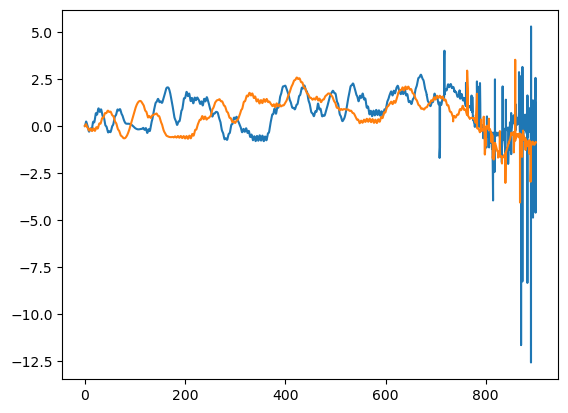

In [145]:
plt.plot(tvals[:9000], np.real(p1[:9000]))
plt.plot(tvals[:9000], np.real(p2[:9000]))
plt.show()
# plt.savefig('m'+str(m)+'cy'+str(cycles)+'.png')

In [104]:
def rk4step(v, t0, h):
    k1 = -1j * temporalBHZ(w1, phi1, w2, phi2, m, t0) @ v
    k2 = -1j * temporalBHZ(w1, phi1, w2, phi2, m, t0 + h/2) @ (v + k1*h/2)
    k3 = -1j * temporalBHZ(w1, phi1, w2, phi2, m, t0 + h/2) @(v + k2*h/2)
    k4 = -1j * temporalBHZ(w1, phi1, w2, phi2, m, t0 + h) @ (v + k3*h)
    final = v + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return (1/la.norm(final))*final

In [118]:
m = 1.5
e, v = la.eig(temporalBHZ(w1, phi1, w2, phi2, m, 0))
psi0 = np.matrix(v[0].reshape(2,1))
cycles = 100
dt = 0.1
tvals = np.arange(0, cycles*2*np.pi/w1, dt)
power1, power2 = [], []
for i in tvals:
    power1.append( (psi0.H @ dh1t(w1, 10, i) @ psi0 ).item())
    power2.append( (psi0.H @ dh2t(w2, phi2, i) @ psi0 ).item())
    psi0 = rk4step(psi0, i, dt)

In [111]:
tvals[0]

0.0

In [110]:
la.eig(temporalBHZ(w1, phi1, w2, phi2, m, 0))

(array([-1.+0.j,  1.+0.j]),
 array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]))

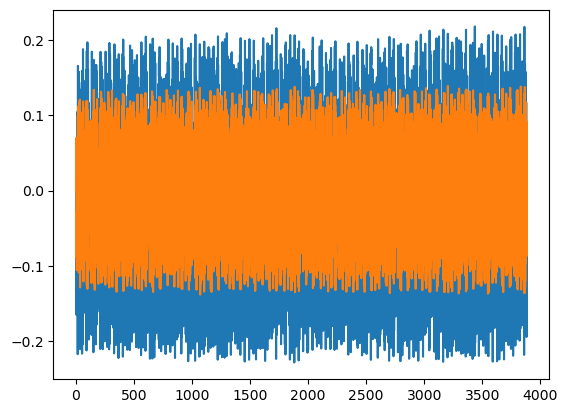

In [119]:
plt.plot(tvals, np.real(power1))
plt.plot(tvals, np.real(power2))

plt.show()